## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/valid.txt'),
 PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/labels'),
 PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/codes.txt'),
 PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/images/0016E5_07770.png'),
 PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/images/0001TP_008520.png'),
 PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/images/Seq05VD_f02790.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/labels/0001TP_008070_P.png'),
 PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/labels/0001TP_006930_P.png'),
 PosixPath('/home/kl/code/course-v3/nbs/dl1/data/camvid/labels/0016E5_05850_P.png')]

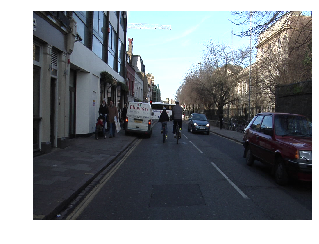

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

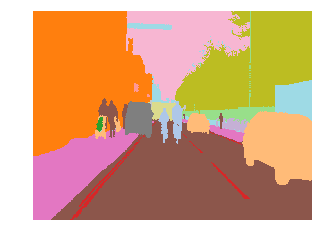

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [12]:
size = src_size//2
bs=8

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

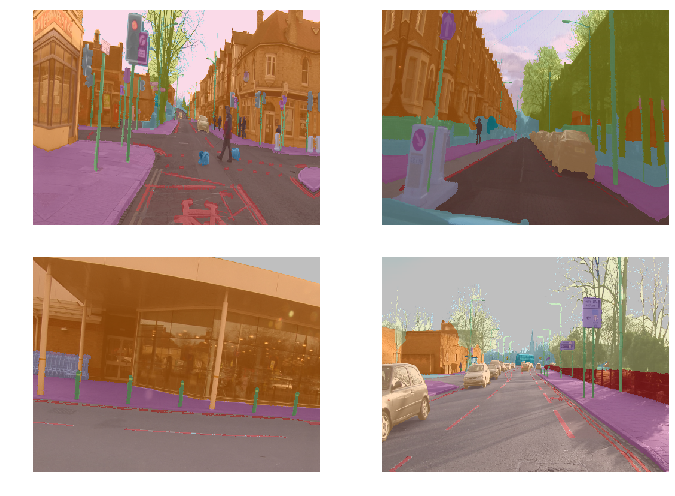

In [15]:
data.show_batch(2, figsize=(10,7))

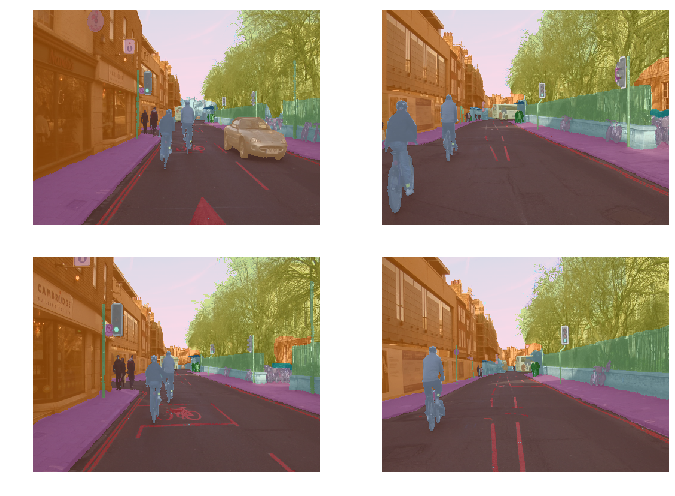

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
class CrossEntropyBuckets(nn.Module):
    def __init__( self, alfa=0.1, prClassLoss=True ):
        super(CrossEntropyBuckets, self).__init__()
        self.alfa=alfa
        self.prClassLoss=prClassLoss
        #self.register_buffer("classOpt",  torch.from_numpy( np.asarray([classOpt]).astype(np.int32) ).byte().cuda() )
        
    def forward(self, x:Tensor, y:Tensor) -> Rank0Tensor:
        bs, nc, cols, rows = x.size()
        xv         = x.permute(0, 2, 3, 1)        #bs,cols,rows, nc
        xv         = xv.contiguous().view(-1, nc) #bs*cols*rows, nc
        yv         = y.view(-1)
    
        xv_argmax  = xv.argmax(dim=1)
        ix_error   = xv_argmax.ne(yv)
        xv         = F.cross_entropy(xv, yv, reduction = "none" )
    
        if self.prClassLoss is False:
            error_loss = xv[ix_error].mean()
            mean_loss  = xv.mean()
            return 0.5*(error_loss*(1-self.alfa) + self.alfa*mean_loss)
        else:
            m_mc=m_ac=count_c=0.
            for i in range(nc):
                #mc: misclassified from class
                #ac: all from class
                ix_mc    = ( (yv==i) + (ix_error==1) ).eq(2)
                ix_ac    = yv.eq(i)
                ix_mc_sum= ix_mc.sum()
                ix_ac_sum= ix_ac.sum()
            
                m_mc     += xv[ix_mc].mean() if ix_mc_sum>0 else 0.
                m_ac     += xv[ix_ac].mean() if ix_ac_sum>0 else 0.
                count_c  += 1                if ix_ac_sum>0 else 0.
            
            return 0.5 * (m_mc*(1-self.alfa) + m_ac*self.alfa) / count_c

In [19]:
class FocalLoss(nn.Module):
    def __init__( self, gamma=2., prClassLoss=True ):
        super(FocalLoss, self).__init__()
        self.gamma=gamma
        self.prClassLoss=prClassLoss
        
    def forward(self, x:Tensor, y:Tensor) -> Rank0Tensor:
        
        bs, nc, cols, rows = x.size()
        xv         = x.permute(0, 2, 3, 1)        #bs,cols,rows, nc
        xv         = xv.contiguous().view(-1, nc) #bs*cols*rows, nc
        yv         = y.view(-1,1)
        
        #its numerically more stable and faster to do log_softmax in 1 operation 
        xv         = F.log_softmax(xv, dim=1)
        #get logsoftmax for the pixel class
        y_lsm      = torch.gather(xv, 1, yv)
        #get the probability for the pixel class
        y_prob     = y_lsm.exp()
        
        #gamma weighting so well classified pixel gets less influence 
        y_prob_w   = (1-y_prob)**self.gamma      
        y_loss     = -y_prob_w * y_lsm
        
        if self.prClassLoss is False:
            return y_loss.mean() / y_prob_w.mean()
        else:
            yv=y.view(-1)
            m=count_c=0.
            for i in range(nc):
                ix      = yv.eq(i)
                ix_sum  = ix.sum()
            
                m       += y_loss[ix].mean() if ix_sum>0 else 0.
                count_c += 1                 if ix_sum>0 else 0.
            
            return m / count_c #/ y_prob_w.mean()
             

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)
#learn.loss_func= CrossEntropyBuckets()
learn.loss_func= FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


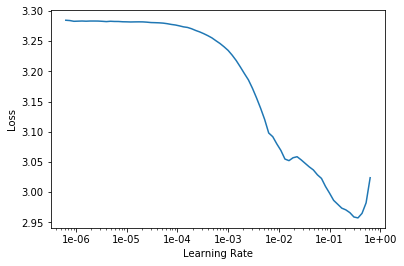

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=1e-2

In [24]:
learn.fit_one_cycle(1, slice(lr), moms=(0.99,0.89))

Total time: 00:28
epoch  train_loss  valid_loss  acc_camvid
1      1.919880    1.529766    0.503276    (00:28)



In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

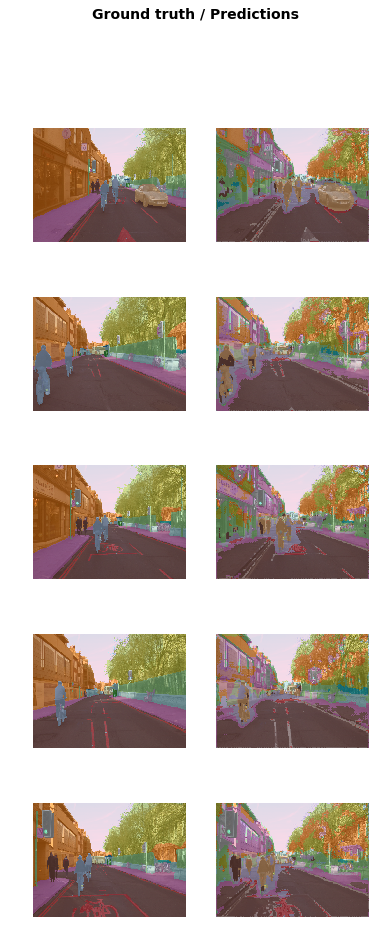

In [27]:
learn.show_results()

In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


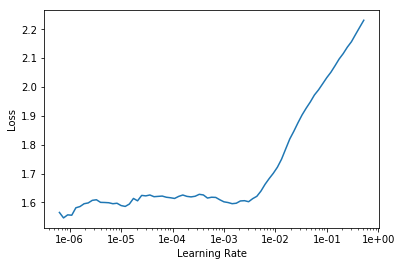

In [29]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lrs = slice(1e-5,lr/5)

In [31]:
learn.fit_one_cycle(12, lrs, moms=(0.99,0.89))

Total time: 05:34
epoch  train_loss  valid_loss  acc_camvid
1      1.506407    1.329305    0.613890    (00:27)
2      1.370058    1.247429    0.631950    (00:27)
3      1.267847    1.243388    0.598709    (00:27)
4      1.191525    1.179206    0.631208    (00:27)
5      1.090324    1.101205    0.705037    (00:27)
6      1.003406    1.104678    0.733026    (00:28)
7      0.911793    1.020926    0.699320    (00:27)
8      0.824226    0.899922    0.717046    (00:27)
9      0.746632    0.929125    0.773649    (00:27)
10     0.696813    0.893312    0.771484    (00:28)
11     0.667001    0.870057    0.768773    (00:28)
12     0.643160    0.886533    0.775137    (00:27)



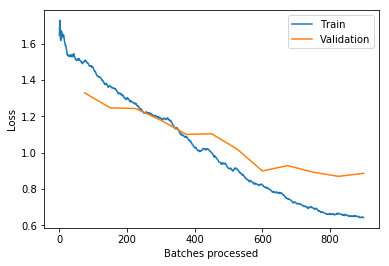

In [32]:
learn.recorder.plot_losses()

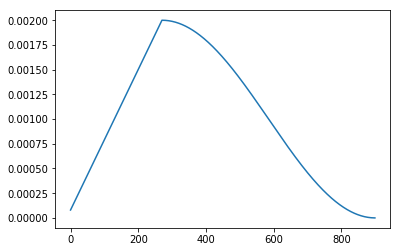

In [33]:
learn.recorder.plot_lr()

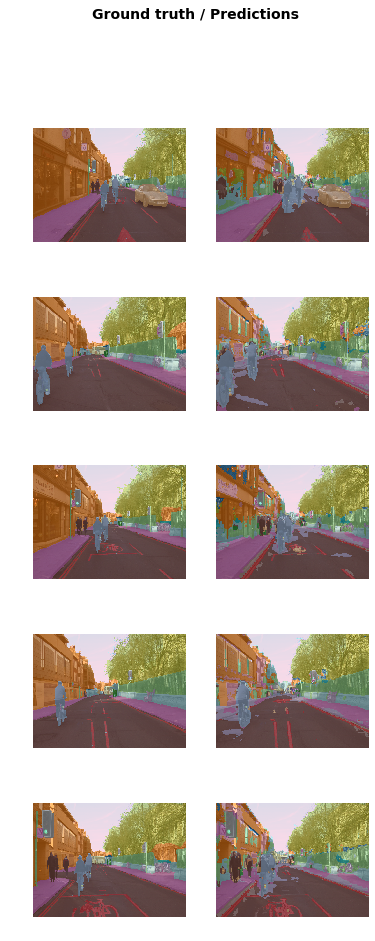

In [34]:
learn.show_results()

In [35]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=4

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr)

In [ ]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

In [ ]:
learn.show_results()